In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse
import datetime
import io
import numpy as np
import scipy.stats as stats

In [2]:
connection = {
    'host': 'http://clickhouse.lhost',
    'password': 'pass',
    'user': 'name',
    'database': 'simulator'
    }

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220520.feed_actions 
WHERE toDate(time) between '2022-04-24' and '2022-04-30'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)

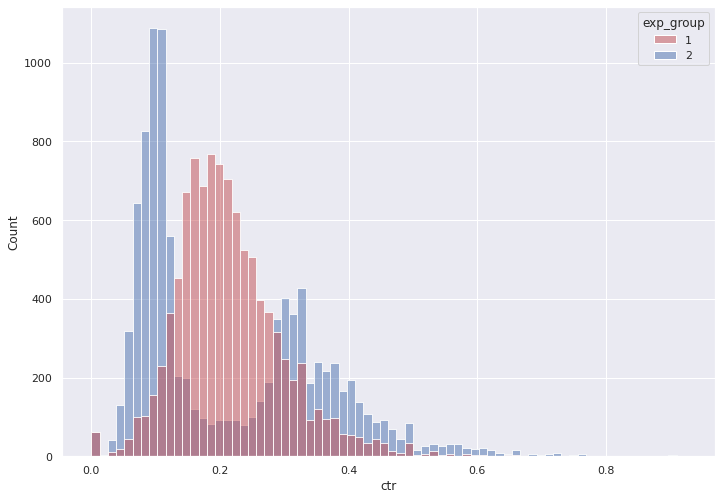

In [3]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

По графику можно сделать вывод, что различия есть, но они неоднородны  <br>
Группа 1 - контрольная <br>
Группа 2 - внесены изменения в приложение <br>
Основная гипотеза: алгоритм во 2-й группе приведет к увеличению CTR <br>
Нулевая гипотеза: значимых различий между группами нет

In [4]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.709439204127032, pvalue=0.47806231308750413)

In [5]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

Тесты продемонстрировали разный результат: согласно t-тесту, значимых различий между экспериментальными группами нет, но согласно двустороннему тесту Манна-Уитни, различия есть <br>
Чтобы найти проблему, оценим группы

In [100]:
df.groupby('exp_group').agg({'ctr': 'count'})
# Размеры выборок практически одинаковые

ctr
exp_group       
1          10079
2           9952

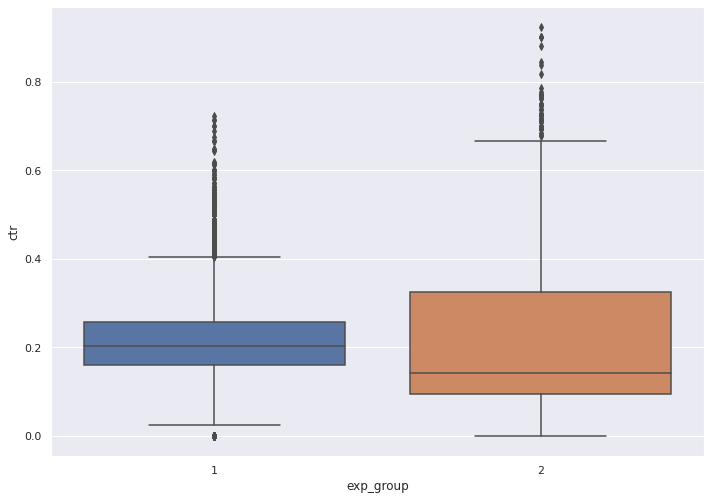

In [101]:
sns.boxplot(x="exp_group", y="ctr", data=df)

Заметим, насколько сильнее выбросы во второй группе и шире диапазон распределения значений. <br>
Очевидно, что CTR во второй группе зашумлен: маловероятно, что у нас так много пользователей с CTR в дипазоне 0.6-1.0 при большом количестве просмотров, это, скорее всего, вызвано малым количеством просмотров и высоким количеством лайков на эти просмотры. <br>
В то же время значительные выбросы в первой группе также имеются: диапазон 0.4 - 0.7 скорее всего тоже объясняется шумом. <br>
Применим функцию сглаженного CTR, а также бутстрапирование

In [102]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr
# Функция сглаживания СTR

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()
# Считаем глобальный CTR для каждой группы

In [103]:
df['smoothed_ctr_1'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
df['smoothed_ctr_2'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)
# Применяем функцию сглаживания, создаем колонки со сглаженным CTR с alpha=5

In [104]:
stats.ttest_ind(df.smoothed_ctr_1,
                df.smoothed_ctr_2,
                equal_var=False)

Ttest_indResult(statistic=1.0507184796987228, pvalue=0.2933942442811584)

In [105]:
stats.mannwhitneyu(df.smoothed_ctr_1, 
                   df.smoothed_ctr_2,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=201971755.0, pvalue=0.2430054363009465)

p-значение изменилось очень заметно, но уровень значимости всё ещё недостаточный для того, чтобы отвергнуть нулевую гипотезу <br>
Должны ли мы остановиться на этом? Едва ли. На распределении ниже мы видим, что CTR действительно сгладился, но выбросы все ещё вносят существенный вклад в результаты сравнения групп

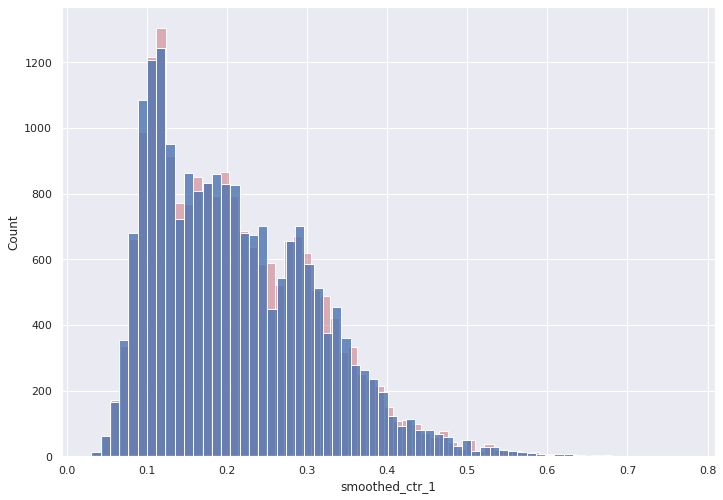

In [106]:
sns.histplot(df.smoothed_ctr_1, color = 'r', alpha = 0.4)
sns.histplot(df.smoothed_ctr_2, color = 'b',  alpha = 0.8)

Применим бутстрап

In [109]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=1000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

# Напишем функцию бутстрапирования

In [110]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

# Создадим переменные с глобальным СTR по каждой группе

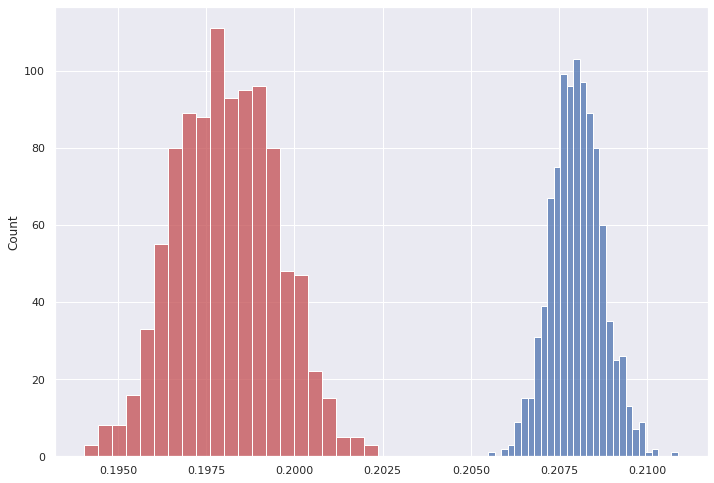

In [111]:
sns.histplot(ctr1)
sns.histplot(ctr2, color = 'r')

Распределения совсем либо почти не пересекаются: это говорит нам о том, что они разные. Но самое страшное - CTR экспериментальное группы находится слева, т.е. показывает результат хуже контроля

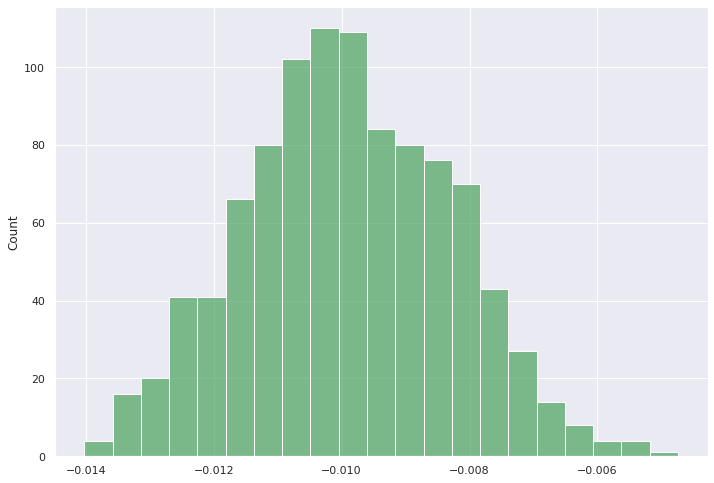

In [112]:
sns.histplot(ctr2 - ctr1, color = 'g')

В доверительный интервал не попадает нулевое значение: пересечений нет и группы различаются. Убедимся в этом при помощи t-теста:

In [113]:
stats.ttest_ind(ctr1,
                ctr2,
                equal_var=False)

Ttest_indResult(statistic=195.49046330111324, pvalue=0.0)

p-value равно нулю, и нам стоит опровергнуть нулевую гипотезу <br>
Применим тест Манна-Уитни, указав в качестве альтернативной гипотезу о том, что в группе с СTR контрольной группы показатель выше 

In [114]:
stats.mannwhitneyu(ctr1, ctr2, alternative="greater")

MannwhitneyuResult(statistic=1000000.0, pvalue=0.0)

Нулевая гипотеза опровергнута: CTR больше во второй, контрольной группе. <br>
Проведем так же бакетное апреобразование на 50 бакетов

In [115]:
q = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20220520.feed_actions 
    WHERE toDate(time) between '2022-04-24' and '2022-04-30'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_bucket = pandahouse.read_clickhouse(q, connection=connection)

# Сформируем запрос с разбиением по бакетам

In [116]:
stats.ttest_ind(df_bucket[df.exp_group == 1].bucket_ctr, 
                   df_bucket[df.exp_group == 2].bucket_ctr,
                   equal_var = False)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Ttest_indResult(statistic=2.3858219840996107, pvalue=0.018981811241632132)

In [117]:
stats.mannwhitneyu(df_bucket[df.exp_group == 1].bucket_ctr, 
                   df_bucket[df.exp_group == 2].bucket_ctr, 
                   alternative = 'greater')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


MannwhitneyuResult(statistic=1594.0, pvalue=0.006032195868383463)

Результат аналогичен: группы не равны, первая(контрольная) группа имеет лучший CTR. <br>
Ну, и взглянем на распределением CTR, выделенного бакетным преобразованием

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


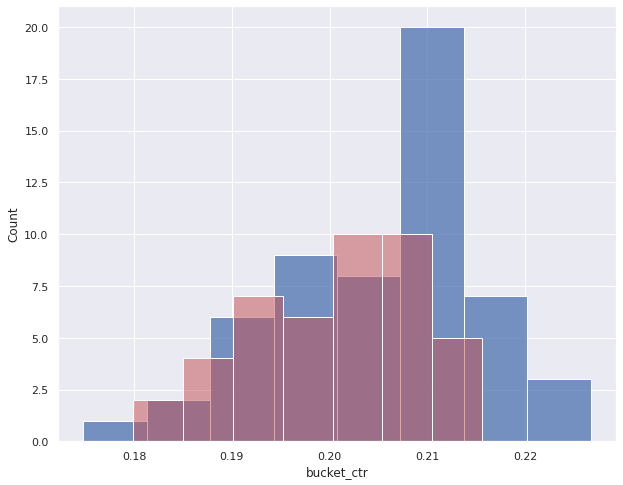

In [118]:
sns.set(rc={'figure.figsize':(10, 8)})
sns.histplot(df_bucket[df.exp_group == 1].bucket_ctr, color = 'b')
sns.histplot(df_bucket[df.exp_group == 2].bucket_ctr, color = 'r', alpha = 0.5)

Изменения выкатывать не стоит <br>
Однако очевидно, что тест не бесполезен: на часть пользователей экспериментальная группа дала CTR выше. Стоит разобраться почему и использовать такую возможность